In [12]:
!pip install pandas

In [8]:
!pip install numpy

In [10]:
!pip install scikit-learn

In [3]:
import numpy as np
import pandas as pd
from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv("BankChurners.csv")

In [1]:
data.head()
# data.info()

NameError: name 'data' is not defined

In [14]:
def get_unique(x: np.ndarray, y: np.ndarray):
    x_set = np.array([x[0, :], ])
    y_set = np.array([y[0]])
    for i in range(len(x)):
        for j in range(len(x_set)):
            if all(x_set[j, :] == x[i, :]):
                break
        else:
            x_set = np.vstack((x_set, x[i, :]))
            y_set = np.vstack((y_set, y[i]))
    return x_set, y_set

In [10]:
data.keys()

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

# dataset preparing

In [31]:
data.shape[1]

8

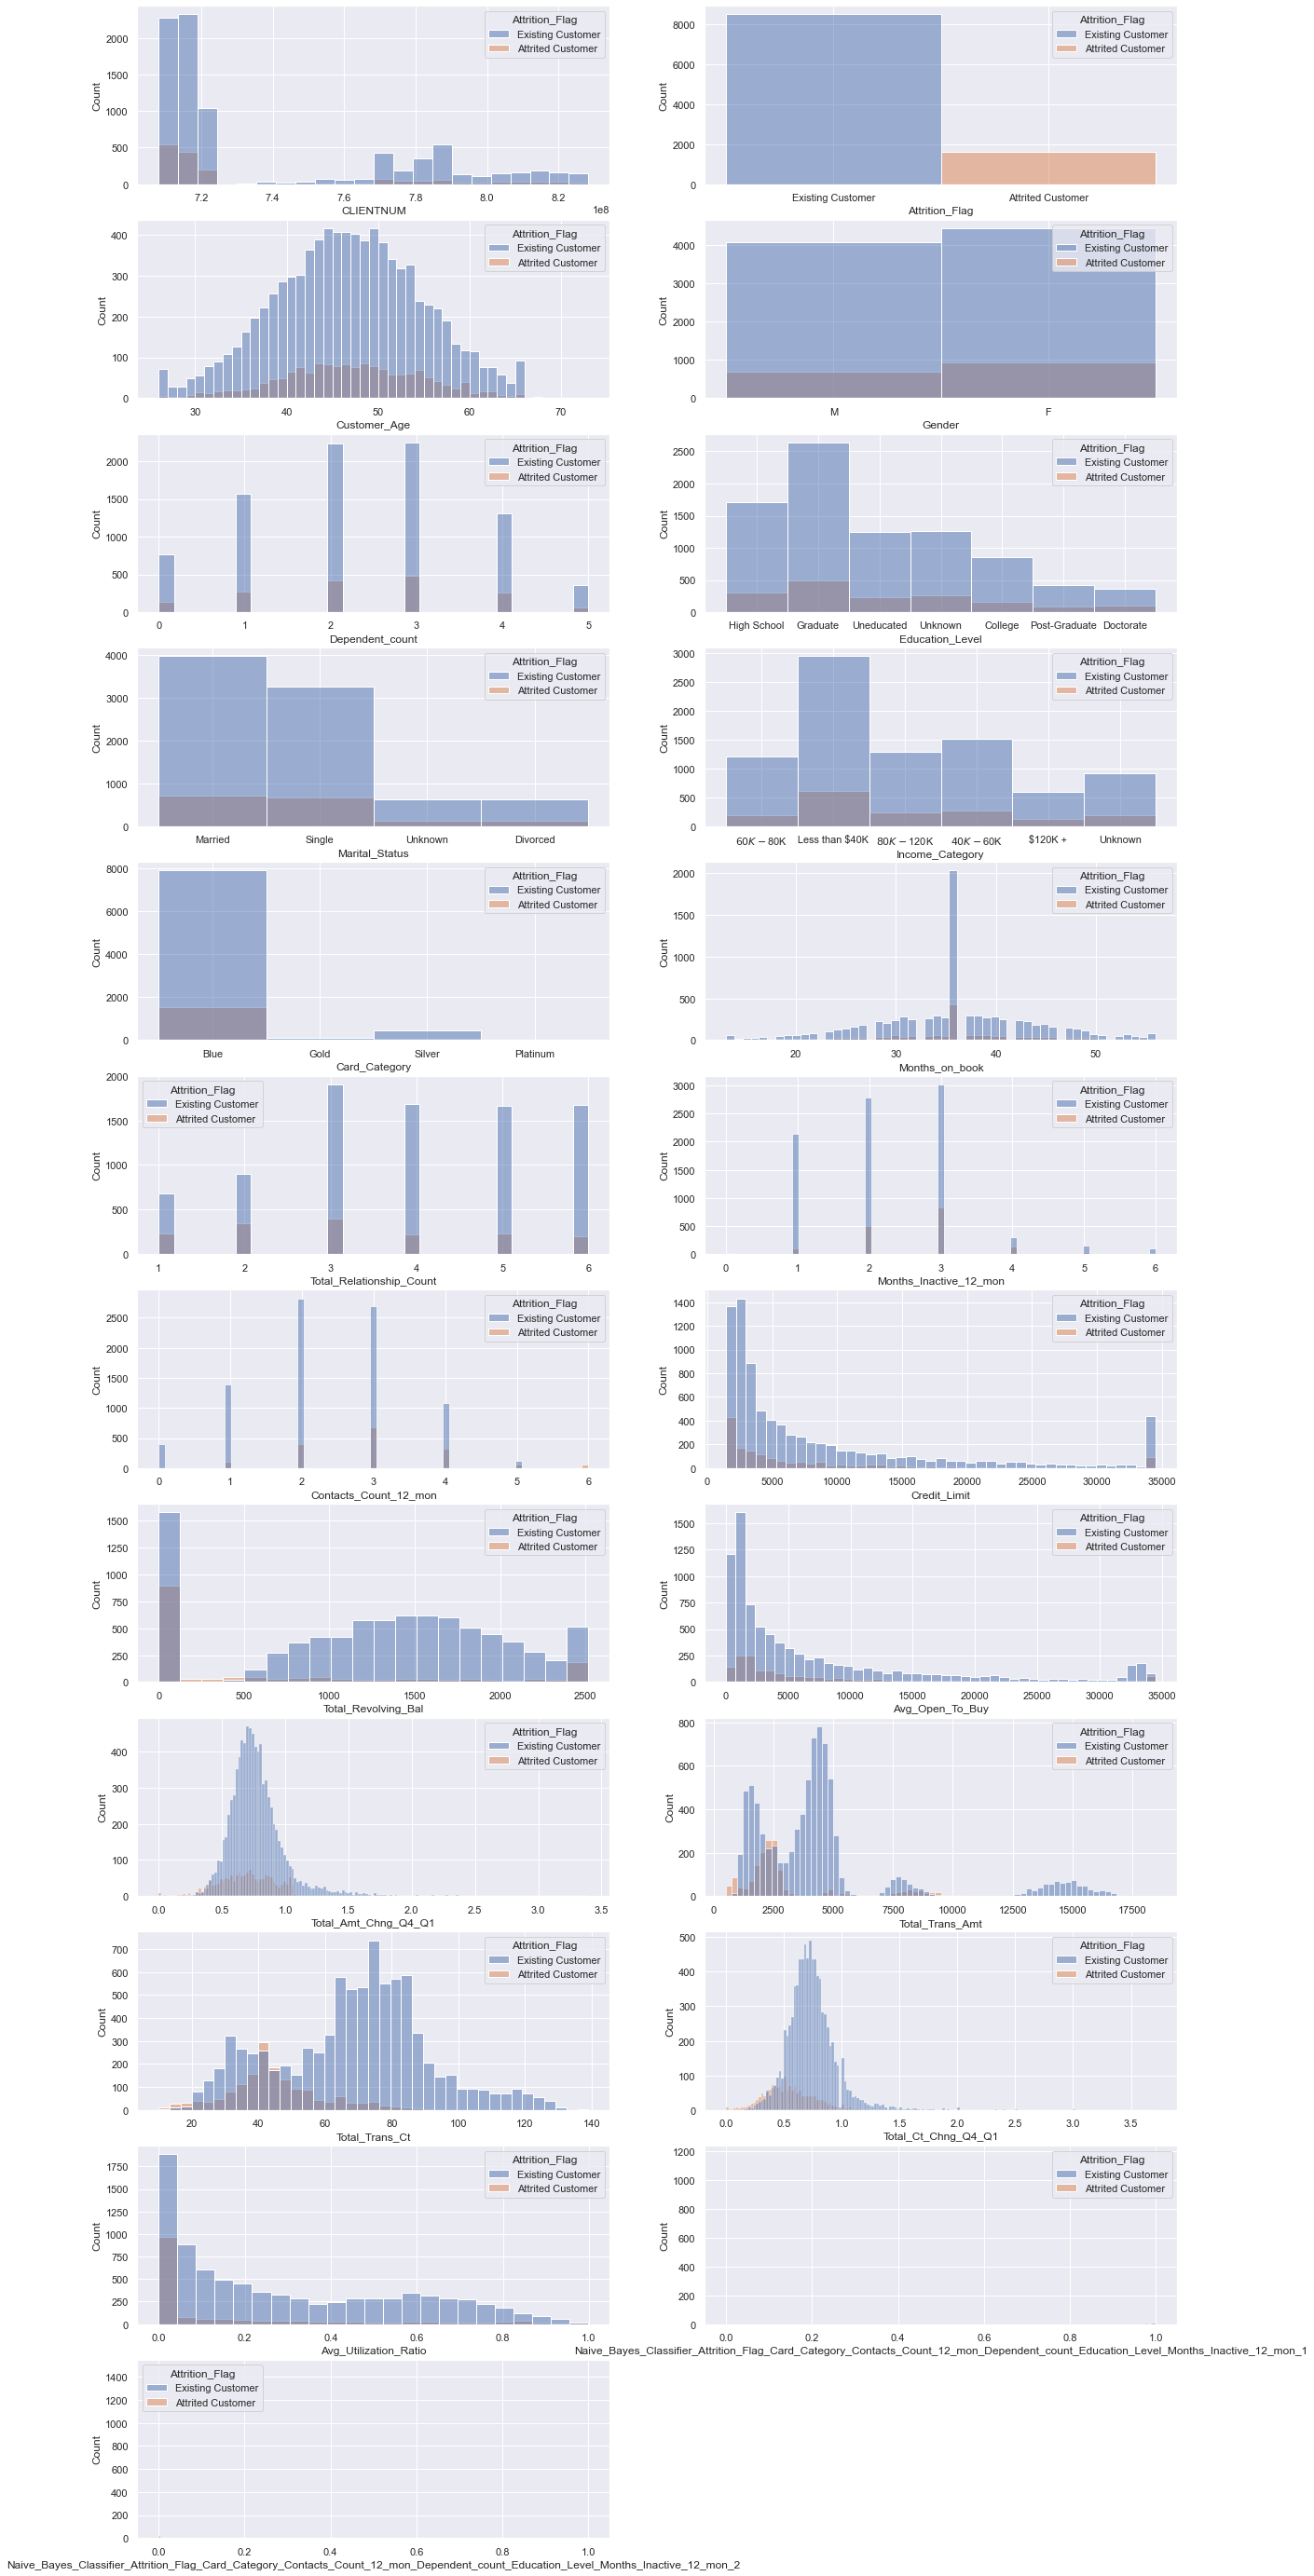

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
bins_number = data["Attrition_Flag"].unique().shape[0]
Le = LabelEncoder()
y = Le.fit_transform(data["Attrition_Flag"].values)
# sns.set(rc={'figure.figsize':(11.7,12)})
plt.figure(figsize=((20, 50)))
figures_numb_in_row = 2
for idx, feature in enumerate(data):
    if(True):
        plt.subplot(data.shape[1] // figures_numb_in_row + (0 if(data.shape[1] % figures_numb_in_row == 0) else 1), 
                    figures_numb_in_row, idx + 1)
        sns.histplot(x=feature, data=data, color="blue", hue="Attrition_Flag")


In [24]:
x = data.drop(["Attrition_Flag"], axis=1).values[0: 1000, :]
trash_features = ["CLIENTNUM", 
                 "Customer_Age", 
                 "Gender", 
                 "Dependent_count", 
                 ""]

In [36]:
# print(data["Attrition_Flag"].values)
data["Education_Level"].unique()

array(['High School', 'Graduate', 'Uneducated', 'Unknown', 'College',
       'Post-Graduate', 'Doctorate'], dtype=object)

In [23]:
x_set, y_set = get_unique(x, y)

In [22]:
x_set

array([[768805383, 45, 'M', ..., 0.061, 9.344799999999999e-05,
        0.9999100000000001],
       [818770008, 49, 'F', ..., 0.105, 5.6861e-05, 0.9999399999999999],
       [713982108, 51, 'M', ..., 0.0, 2.1081e-05, 0.99998],
       ...,
       [716506083, 44, 'F', ..., 0.0, 0.9978799999999999, 0.00211827],
       [717406983, 30, 'M', ..., 0.0, 0.99671, 0.00329379],
       [714337233, 43, 'F', ..., 0.18899999999999997, 0.9966200000000001,
        0.00337654]], dtype=object)

In [28]:
y_set.shape


(10127, 1)